<a href="https://colab.research.google.com/github/dougrasbh/pos-trab2-modulo3/blob/main/trab_pos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Atividade Avaliativa: Projeto prático com uso de LLMs

- Atividade avaliativa referente a disciplina Programação para Ciência dos Dados
- Professor: Thiago Eugenio de Melo

<br/>

**Membros da Equipe:**

- Ademir Guimarães
- Arthur Bezerra
- Debora Barros
- Keven Gomes
- Pedro Carvalho
- Ronald Boadana

## Instalação de Dependências Necessárias

In [ ]:
%pip install dotenv requests chromadb kaggle

## Bibliotecas necessárias

In [ ]:
# importar bibliotecas necessárias
import pandas as pd
import seaborn as sns
import string
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')

import os
import json
from dotenv import load_dotenv
import chromadb
import requests
import time
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Explorando o dataset

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ronaldboadana","key":"ea7d5c0d0e085571ca17dc72cfb65467"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c nlp-getting-started
!unzip nlp-getting-started.zip -d nlp-getting-started

nlp-getting-started.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  nlp-getting-started.zip
replace nlp-getting-started/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: nlp-getting-started/sample_submission.csv  
  inflating: nlp-getting-started/test.csv  
  inflating: nlp-getting-started/train.csv  


In [ ]:
# importar o dataset
train_df = pd.read_csv('nlp-getting-started/train.csv')

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
# Volume do dataset
train_df.shape

(7613, 5)

In [ ]:
# Tipos de atributos
train_df.dtypes

,0
id,int64
keyword,object
location,object
text,object
target,int64


In [ ]:
# Resumo do dataset
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
# Dados ausentes
train_df.isnull().sum()

,0
id,0
keyword,61
location,2533
text,0
target,0


In [ ]:
# Distribuição de classes
train_df['target'].value_counts()

,count
target,
0,4342
1,3271


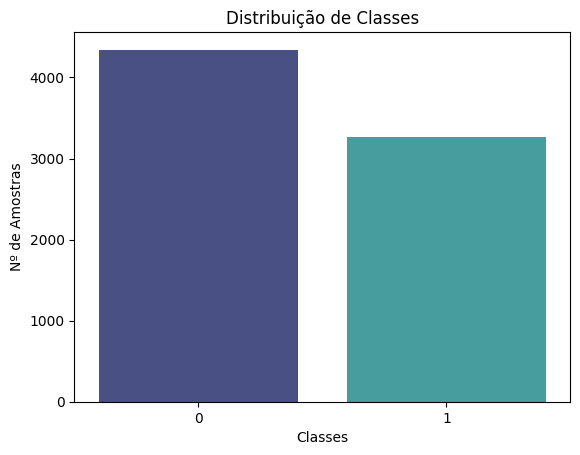

In [ ]:
# Gráfico da Distribuição de classes
sns.countplot(data=train_df, x='target', hue='target', palette='mako', legend=False)
plt.title('Distribuição de Classes')
plt.xlabel('Classes')
plt.ylabel('Nº de Amostras')
plt.grid(False)
plt.show()

## Pré-processamento dos dados

In [ ]:
# removendo colunas irrelevantes
train_df = train_df.drop(['id', 'location', 'keyword'], axis=1)

train_df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
# convertendo para lowercase
train_df["text"] = train_df["text"].str.lower()
train_df.head()

,text,target
0,our deeds are the reason of this #earthquake m...,1
1,forest fire near la ronge sask. canada,1
2,all residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,just got sent this photo from ruby #alaska as ...,1


In [ ]:
# removendo pontuações
exclude = set(string.punctuation)

def remove_punctuation(x):
  try:
    x = ''.join(ch for ch in x if ch not in exclude)
  except:
    pass
  return x


train_df['text'] = train_df['text'].apply(remove_punctuation)
train_df.head()

,text,target
0,our deeds are the reason of this earthquake ma...,1
1,forest fire near la ronge sask canada,1
2,all residents asked to shelter in place are be...,1
3,13000 people receive wildfires evacuation orde...,1
4,just got sent this photo from ruby alaska as s...,1


In [ ]:
# removendo stopwords
stop = stopwords.words('english')

def remove_stopwords(x):
  return ' '.join([word for word in x.split() if word not in (stop)])

train_df['text'] = train_df['text'].apply(remove_stopwords)
train_df.head()

,text,target
0,deeds reason earthquake may allah forgive us,1
1,forest fire near la ronge sask canada,1
2,residents asked shelter place notified officer...,1
3,13000 people receive wildfires evacuation orde...,1
4,got sent photo ruby alaska smoke wildfires pou...,1


In [ ]:
# Transformando o target em string
mapeamento = {0: "It's not a real disaster", 1: "It's a real disaster"}
train_df['target'] = train_df['target'].map(mapeamento)

## Aplicação LLM - Few Shot

In [ ]:
# Separar a base de dados em treino e teste
train_df_rag, test_df_rag = train_test_split(train_df, test_size=0.1, random_state=42)

In [ ]:
# transformar df em um arquivo txt
col_text = 'text'
col_target = 'target'

format = [
    f'Tweet: {line[col_text]}\nTarget: {line[col_target]}\n'
    for _, line in train_df_rag.iterrows()
]

with open('tweets.txt', 'w', encoding='utf-8') as f:
  f.write('\n'.join(format))

In [ ]:
load_dotenv()

# API KEY GROQ
groq_api_key = os.getenv("GROQ_API_KEY")

groq_model = os.getenv("GROQ_MODEL")

# Inicializar ChromaDB (BD vetorial)
client = chromadb.Client()
collection = client.create_collection('tweets-rag')

In [ ]:
# modelo de embeddings
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

def get_embedding(text):
  return embedding_model.encode(text).tolist()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# ler as info do txt -> gerar os embeddings -> salvar no bd vetorial
def insert_data(file_path):
  with open(file_path, 'r', encoding='utf-8') as f:
    content = f.read()

  entries = content.strip().split('\n\n')
  for i, entry in enumerate(entries):
    lines = entry.strip().split('\n')
    tweet = lines[0].strip()
    target = lines[1].strip()
    full_text = f"{tweet}\n{target}"

    embedding = get_embedding(full_text)

    collection.add(
        documents=[full_text],
        metadatas=[{"text": full_text}],
        embeddings=[embedding],
        ids=[f"id-{i}"]
    )

In [ ]:
# buscar contexto relevante com base na pergunta
def retrieve_context(query, top_k=3):
  query_embedding = get_embedding(query)
  results = collection.query(
      query_embeddings=[query_embedding],
      n_results=top_k
  )
  documents = results['documents'][0] if results['documents'] else []
  return "\n---\n".join(documents)

In [ ]:
def ask_groq(query, context):
    prompt = f"""
Use o contexto abaixo para categorizar um tweet:

Contexto:
{context}

Tweet:
{query}

Essa será sua response de saída, conforme a seguir. Responda SOMENTE com o target apropriado no seguinte formato como json:

{{
  "target": "It's not a real disaster"
}}

Ou:

{{
  "target": "It's a real disaster"
}}
"""
    response = requests.post(
        "https://api.groq.com/openai/v1/chat/completions",
        headers={"Authorization": f"Bearer {groq_api_key}"},
        json={
            "model": groq_model,
            "messages": [
                {"role": "system", "content": "Você é um assistente que responde com base no contexto fornecido."},
                {"role": "user", "content": prompt}
            ],
            "temperature": 0.1
        }
    )
    return response.json()['choices'][0]['message']['content']

In [ ]:
# extraindo as informações do json como resposta
def extract_target(pred_str):
    try:
        pred_dict = json.loads(pred_str)
        return pred_dict['target']
    except Exception:
        return None

In [ ]:
insert_data("tweets.txt")

In [ ]:
# limitando o dataset de testes para 100 registros
# sample_test = test_df_rag.sample(100, random_state=42)

# Usando os dados de teste
predictions = []

for _, row in test_df_rag.iterrows():
    tweet = row[col_text]
    true_label = row[col_target]
    context = retrieve_context(tweet)

    raw_response = ask_groq(tweet, context)

    predicted_label = extract_target(raw_response)

    predictions.append({
        "tweet": tweet,
        "true_target": true_label,
        "predicted_target": predicted_label
    })


test_df_result = pd.DataFrame(predictions)

In [ ]:
test_df_result.head()

,tweet,true_target,predicted_target
0,new weapon cause unimaginable destruction,It's a real disaster,It's not a real disaster
1,famping things gishwhes got soaked deluge goin...,It's not a real disaster,It's not a real disaster
2,dt georgegalloway rt galloway4mayor ûïthe col...,It's a real disaster,It's not a real disaster
3,aftershock back school kick great want thank e...,It's not a real disaster,It's not a real disaster
4,response trauma children addicts develop defen...,It's not a real disaster,It's not a real disaster


In [ ]:
# Avaliando os resultados
y_true = test_df_result['true_target']
y_pred = test_df_result['predicted_target']

print('Métricas de avaliação do modelo que usa RAG')

def metrics(y_true, y_pred):
  acc = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred, average='weighted')
  recall = recall_score(y_true, y_pred, average='weighted')
  f1 = f1_score(y_true, y_pred, average='weighted')

  print(f'Acurácia: {acc:.2f}')
  print(f'Precisão: {precision:.2f}')
  print(f'Revocação: {recall:.2f}')
  print(f'F1-Score: {f1:.2f}')


metrics(y_true, y_pred)

Métricas de avaliação do modelo que usa RAG
Acurácia: 0.75
Precisão: 0.75
Revocação: 0.75
F1-Score: 0.75


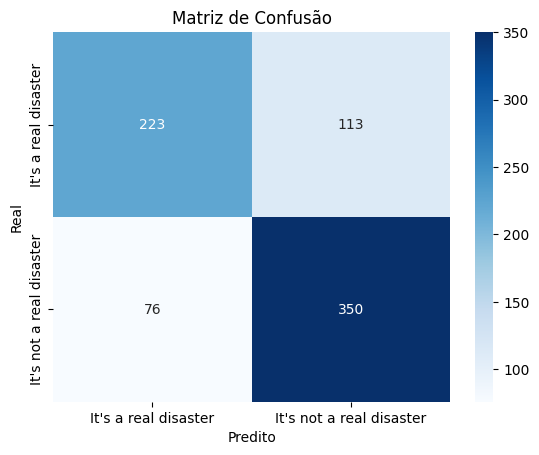

In [ ]:
# Plotando a matriz de confusão
def conf_matrix(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred, labels=["It's a real disaster", "It's not a real disaster"])

  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=["It's a real disaster", "It's not a real disaster"],
              yticklabels=["It's a real disaster", "It's not a real disaster"])
  plt.xlabel("Predito")
  plt.ylabel("Real")
  plt.title("Matriz de Confusão")
  plt.show()


conf_matrix(y_true, y_pred)

## Aplicação LLM - Zero Shot

In [ ]:
def ask_groq2(query):
    prompt = f"""
Categorize o seguinte tweet:

{query}
"""
    response = requests.post(
        "https://api.groq.com/openai/v1/chat/completions",
        headers={"Authorization": f"Bearer {groq_api_key}"},
        json={
            "model": groq_model,
            "messages": [
                {"role": "system", "content": """Você é um especialista em categorização de tweets.

                                                 Responda SOMENTE com o target apropriado no seguinte formato como json:
                                                  {{
                                                    "target": "It's not a real disaster"
                                                  }}

                                                  Ou:

                                                  {{
                                                    "target": "It's a real disaster"
                                               }}"""},
                {"role": "user", "content": prompt}
            ],
            "temperature": 0.1
        }
    )

    return response.json()['choices'][0]['message']['content']

In [ ]:
# Usando os dados de teste
predictions = []

for _, row in test_df_rag.iterrows():
    tweet = row[col_text]
    true_label = row[col_target]
    raw_response = ask_groq2(tweet)
    predicted_label = extract_target(raw_response)

    predictions.append({
        "tweet": tweet,
        "true_target": true_label,
        "predicted_target": predicted_label
    })

result_without_rag = pd.DataFrame(predictions)

In [ ]:
result_without_rag.head()

,tweet,true_target,predicted_target
0,new weapon cause unimaginable destruction,It's a real disaster,It's a real disaster
1,famping things gishwhes got soaked deluge goin...,It's not a real disaster,It's not a real disaster
2,dt georgegalloway rt galloway4mayor ûïthe col...,It's a real disaster,None
3,aftershock back school kick great want thank e...,It's not a real disaster,None
4,response trauma children addicts develop defen...,It's not a real disaster,It's not a real disaster


In [ ]:
# removendo registros que o predict foi None (modelo não conseguiu inferir)
display(result_without_rag.shape)
result_without_rag = result_without_rag[result_without_rag['predicted_target'].notnull()]
display(result_without_rag.shape)

(762, 3)

(681, 3)

In [ ]:
# Avaliando os resultados
y_true = result_without_rag['true_target']
y_pred = result_without_rag['predicted_target']

print('Métricas de avaliação do modelo sem uso de RAG')

# métricas
metrics(y_true, y_pred)

Métricas de avaliação do modelo sem uso de RAG
Acurácia: 0.73
Precisão: 0.74
Revocação: 0.73
F1-Score: 0.73


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


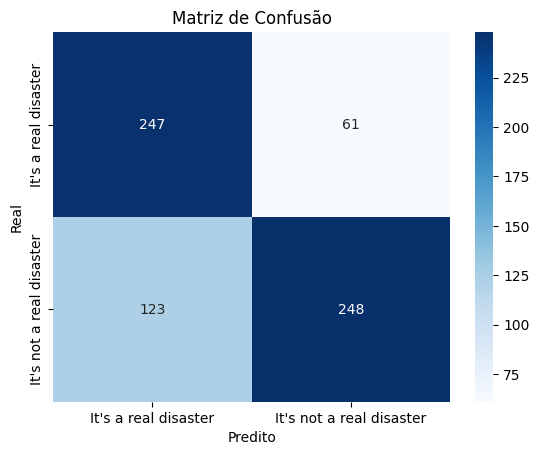

In [ ]:
# plotando a matriz de confusão
conf_matrix(y_true, y_pred)